<a href="https://colab.research.google.com/github/dzeke/ColoradoRiverCollaborate/blob/main/Powell10year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Colorado River reservoir data from Reclamation
## David E. Rosenberg
## February 27, 2024

## Overview
This is a Jupyter Notebook (.ipynb). This document reads daily Reclamation data for Colorado River reservoirs from U.S. Bureau of Reclamation's (Reclamation) web portal https://www.usbr.gov/uc/water/hydrodata/reservoir_data/919/csv/25.csv). Here, as an example, *919* is the code for Lake Powell. And *25* is the code for reservoir evaporation.

First the code reads in the Metadata for all available reservoirs and data fields from the file 'https://raw.githubusercontent.com/dzeke/ColoradoRiverCollaborate/main/Powell10year/AsPython/ReclamationMetaData.csv.' This metadata includes reservoir name, site id, field name, field ids, units of measurement, and so forth.

Second, the code then iterates over all specified reservoirs and reads in the associated data fields.

Third, the code combines data for all the fields into a database (Pandas dataframe). The database has the columns:
    Date_Raw, Value, Reservoir_ID, Reservoir_Name, Field_ID, Field_Name, Units.
    
Fourth, the code then aggregates data to yearly (water year starting Oct 1).

Fifth, the code plots data for different reservoirs and fields. For example:

 + Evaporation
 + Total evaporation for each period of consecutative 10 years

## Directions to Open, Edit, and Run (Windows)
1. Download all the files into a new local folder on your machine or storage device (e.g., c:\users\myfolder).
2. Open a command prompt (c:\).
3. Install the Juptyer server. At the command prompt type:
    >> pip install jupyter
4. Navigate to the folder where this file is stored. For example:
    >> cd C:\users\myfolder
5. Type the command:
    >> jupyter notebook
6. A new webpage will open in your browser with the url *http://localhost:8888/tree.*
7. Select this file from the list -- **PowellDataImport.ipynb**.
8. This page will display.
9. Select the first cell -- e.g., block [19] to run or edit. You should see the follow output:
    >> A list of numbers from 912 to 923. The reservoir codes.
    >> A list of reservoir names and numbers to the right. e.g.
            Blue Mesa Reservoir 16.
                Here, 16 indicates the number of data fields for the reservoir. e.g, Inflow, Storage, Evaporation, etc.
11. Run each successive cell.

## Requested Citation
David E. Rosenberg (2021), “Import Lake Powell Data from Reclamation.” Utah State University. Logan, Utah.
https://github.com/dzeke/ColoradoRiverCollaborate/tree/main/Powell10year/AsPython.

### Pandas Cheat Sheet
Pandas cheat sheet at https://pandas.pydata.org/docs/user_guide/10min.html.

In [27]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

# Add this command on first run of cell
#!pip install plotnine
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

# Show all records for a pandas data frame
pd.set_option('display.max_rows', None)

# Load the meta data from a csv file on Github
MetaDataAsUrl = 'https://raw.githubusercontent.com/dzeke/ColoradoRiverCollaborate/main/Powell10year/AsPython/ReclamationMetaData.csv'
dfMeta = pd.read_csv(MetaDataAsUrl)

#Define the reservoir codes we are interested in for the Upper and Lower Colorado River basins
lResCodes = list(range(912,924,1))  # Taylor Park, Blue Mesa, Morrow Point, Crystal, Fontenelle, Flaming Gorge, Lake Powell, Navajo, Lake Mead,
                                    # Lake Mohave, Lake Havasu

lResCodes = list(range(919,921,1)) # Lake Powell, Navajo, Lake Mead

#Filter on the reservoirs in lResCodes - https://www.kdnuggets.com/2022/12/five-ways-conditional-filtering-pandas.html
dfReservoirData = dfMeta.query('site_id.isin(@lResCodes)')
# Reset the indix
dfReservoirData = dfReservoirData.reset_index()

#Count number of fields per reservoir
#dfReservoirFields = pd.DataFrame(dfReservoirData.groupby('site_metadata.site_name').size().reset_index())

#Count number of fields per reservoir and also show the reservoir ID
dfReservoirFields = pd.DataFrame(dfReservoirData.groupby(['site_metadata.site_name', 'site_id']).size().reset_index())

#lReservoirFieldsColNames = list(dfReservoirFields.columns.values)
#print(lReservoirFieldsColNames)
# Change the third column to be Number of Fields
dfReservoirFields.columns = ['Reservoir', 'Site_ID', 'Number of Fields']

print(lResCodes)
print(dfReservoirFields)
print(dfReservoirData)
print()

# Get the column names
lResColumnNames = dfReservoirData.columns
#Subset the list of column names to those we want
#lResColumnsUse = list(lResColumnNames[i] for i in [1, 2, 4, 5, 10, 26, 27, 28, 29, 30, 31, 32] )
lResColumnsUse = list(lResColumnNames[i] for i in [2, 3, 5, 6, 11, 27, 28, 29, 30, 31, 32, 33] )

#print(lResColumnsUse)
print()

[919, 920]
          Reservoir  Site_ID  Number of Fields
0       LAKE POWELL      919                17
1  NAVAJO RESERVOIR      920                14
    index  site_datatype_id  site_id  datatype_id  site_metadata.site_id  \
0      93              1712      919           15                    919   
1      94              1719      919           17                    919   
2      95              1774      919           25                    919   
3      96              1792      919           29                    919   
4      97              1840      919           30                    919   
5      98              1851      919           33                    919   
6      99              1856      919           34                    919   
7     100              1862      919           39                    919   
8     101              1872      919           42                    919   
9     102              1920      919           43                    919   
10    103   

In [28]:
# Load the data from Reclamation's webservice for each reservoir and each field
#Create a new empty data frame. Rename Reclamation field names to more useful headers."
lColumnsNewName = ['Date_Raw', 'Value', 'Reservoir_ID', 'Field_ID', 'Reservoir_Name', 'Reservoir_CommonName',  'Basin', 'Field_Name', 'Field_CommonName', 'Balance_Component', 'Unit_ID', 'Unit_Name', 'Unit_CommonName', 'Interval']
    
dfAllData = pd.DataFrame(columns = lColumnsNewName)

print(type(dfReservoirData))
#print(dfReservoirData.columns.tolist())
print(f'Number of Columns of dfReservoirData: {len(dfReservoirData.columns)}')
print(f'Number of Rows of dfReservoirData: {len(dfReservoirData)}')

#Select site_id for rows :3
#print(dfReservoirData.index)
#print(dfReservoirData.loc[1])
#print(dfReservoirData.iloc[int(1), 'site_id'])
#

print(pd.DataFrame(lResColumnNames, columns = ['RawName']))

# Creat a data frame with raw and new columns to check correspondence
dfColumnsCheck = pd.DataFrame(list(zip(lColumnsNewName[2:], lResColumnsUse)),
                                   columns = ['NewName', 'RawName'])
#print(f'dfColumnsCheck: {dfColumnsCheck}')

print()

print(dfAllData)

# Set the url for the Reclamation servier with the data. Example for evaporation from Lake Powell
sEvapDataAsUrl = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/919/csv/25.csv'

#Loop over the records in the dfReservoirData dataframe - https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
for i in range(0,18):
#for i in range(len(dfReservoirData)):  
    #Construct the Url from the reservoir id and field id
    #print(df.loc[i, "Name"], df.loc[i, "Age"])
    #dfReservoirData.get('site_id', default = "no_sid")
    #dfReservoirData.get('datatype_id', default = "no_fid")
    try:
        sResID = str(dfReservoirData.loc[i, 'site_id'])
    except KeyError:
        print("Couldn't find a match for the key:", i)

    #sResID = str(dfReservoirData.loc[i, 'site_id'])
    sFieldID = str(dfReservoirData.loc[i, 'datatype_id'])

    #sResID = '919'
    #sFieldID = '25'
    sURL = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/' + sResID + '/csv/' + sFieldID + '.csv' 

    print(sURL)
    # Retrieve and move the dataset for the current reservoir and field into a Pandas Dataframe
    try:
        dfCurr = pd.read_csv(sURL)
    except:
        print(f'Not read: sURL')
        continue

    # Change the column names of the first two columns to Date_Raw, Value
    dfCurr.columns = [lColumnsNewName[0], lColumnsNewName[1]]

    #Loop over the remaining columns, transfer meta data from dfReservoirData to current dataframe
    #for j in range(2,4):
    for j in range(2,len(lColumnsNewName)):
        #print(f'{j} - {lColumnsNewName[j]} - {lResColumnsUse[j-2]}')
        #dfReservoirData.get(lResColumnsUse[j-2])
        dfCurr[lColumnsNewName[j]] = dfReservoirData.loc[i, lResColumnsUse[j-2]]
    
    #print(dfCurr.head())

    # Append the current data to the big data frame\n",
    if i == 0:
        dfAllData = dfCurr
    else:
        frames = [dfAllData, dfCurr]
        dfAllData = pd.concat(frames, ignore_index=True)

print(dfAllData.dtypes)
print(dfAllData.head())


<class 'pandas.core.frame.DataFrame'>
Number of Columns of dfReservoirData: 38
Number of Rows of dfReservoirData: 31
                                     RawName
0                                      index
1                           site_datatype_id
2                                    site_id
3                                datatype_id
4                      site_metadata.site_id
5                    site_metadata.site_name
6             site_metadata.site_common_name
7                  site_metadata.description
8                    site_metadata.elevation
9                          site_metadata.lat
10                       site_metadata.longi
11                site_metadata.db_site_code
12               site_metadata.objecttype_id
13             site_metadata.objecttype_name
14                    site_metadata.basin_id
15             site_metadata.hydrologic_unit
16                  site_metadata.river_mile
17                  site_metadata.segment_no
18                    site_m

In [30]:
# Now clean the big data frame
# Convert raw date to formal date
dfAllData['date'] = pd.to_datetime(dfAllData['Date_Raw'])

#Add year and month columns
dfAllData['year'] = pd.DatetimeIndex(dfAllData['date']).year
dfAllData['month'] = pd.DatetimeIndex(dfAllData['date']).month

#Calculate the water year, Increment by 1 year, Months 10, 11, 12
dfAllData['wateryear'] = dfAllData['year']
dfAllData.loc[dfAllData['month'] >= 10, 'wateryear'] = dfAllData['year'] + 1

#print(dfAllData.head())
nRows = len(dfAllData)

print(f'Number of rows read: {nRows}')
# https://www.geeksforgeeks.org/get-unique-values-from-a-column-in-pandas-dataframe/
print(f'Unique Reservoirs: {dfAllData.Reservoir_CommonName.unique()}')
print(f'Unique Fields: {dfAllData.Field_CommonName.unique()}')
print(f'Unique Field IDs: {dfAllData.Field_ID.unique()}')
#print(dfAllData.head())

Number of rows read: 354298
Unique Reservoirs: ['LAKE POWELL' 'NAVAJO']
Unique Fields: ['bank storage' 'storage' 'evaporation' 'inflow' 'inflow volume'
 'unregulated inflow' 'unregulated inflow volume' 'power release'
 'total release' 'release volume' 'pool elevation' 'power release volume'
 'spillway release' 'bypass release' 'bypass release volume'
 'delta storage' 'area']
Unique Field IDs: [  15   17   25   29   30   33   34   39   42   43   49   40   46 1197
 1198   47   89]


In [32]:
### Select a reservoir and field to retrieve
resID = [919]
fieldID = [25]
AggregateOptions = ['Day', 'Month', 'Year', 'TenYear'] # Aggregate daily data to time interval
Aggregate = AggregateOptions[2]

#Query on the resID and fieldID
dfResField = dfAllData.query('Reservoir_ID.isin(@resID) and Field_ID.isin(@fieldID)')

#dfResField = dfAllData.query('Reservoir_ID == 919 and Field_ID == 25')
#print(dfResField.head())



In [36]:
### Further Process the field based on the aggregate option

if Aggregate == AggregateOptions[0]:
    # Daily, return same data frame
    dfResFieldAgg = dfResField
    
elif Aggregate == AggregateOptions[1]:
    # Daily to Monthly
    pass
    
elif Aggregate == AggregateOptions[2]:
    # Daily to Annual
    
    # Trim water years with less than 360 days
    # Calculate number of days/records for each water year
    dfDaysPerWaterYear = pd.DataFrame(dfResField.groupby(['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear']).size().reset_index())
    # Rename the column name 0 to DaysPerYear
    dfDaysPerWaterYear.columns = ['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear', 'DaysPerYear']
    # Filter to years with more than 360 days / records
    dfFullYears = dfDaysPerWaterYear.query('DaysPerYear >= 360')

    # Check the full years
    print(dfDaysPerWaterYear.head)
    print(dfFullYears.head())
    
    # Aggregate to annual values
    dfWaterYear = dfResField.groupby(['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear'])[['Value']].sum().reset_index()    # Pull value for last day in water use for fields with Intervals 'either'
    # Sum values over water year fro fields with Intervals 'non-instantaneous'
    
    #lInterval = list('either')
    ##dfReservoirData = dfMeta.query('site_id.isin(@lResCodes)')
    ##https://www.kdnuggets.com/2022/12/five-ways-conditional-filtering-pandas.html
    #filter_a = dfResField['Interval'].isin(lInterval)
    #dfInstant = dfResField[filter_b]

    # Left join to only include Water Years with more than 360 days
    #dfAllDataWaterYear = dfFullYears.merge(dfAllDataWaterYear, on='wateryear', how='left')
    dfWaterYear = dfFullYears.merge(dfWaterYear, on=['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear'], how='left')
   
    # Turn acre-feet into million acre-feet
    dfWaterYear.Value = dfWaterYear.loc[dfWaterYear['Unit_ID'] == 1, ['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear']] = dfWaterYear.Value / 1e6

    print()
    print(dfWaterYear.dtypes)
    print(dfWaterYear)

    dfResFieldAgg = dfResField

else:
    # Daily to consecutive 10-years
    pass

#dfEvapWaterYear['date'] = pd.to_datetime(dfEvapWaterYear['wateryear'])

<bound method NDFrame.head of     Reservoir_ID  Field_ID Field_CommonName  Unit_ID Unit_CommonName  \
0            919        25      evaporation        1       acre-feet   
1            919        25      evaporation        1       acre-feet   
2            919        25      evaporation        1       acre-feet   
3            919        25      evaporation        1       acre-feet   
4            919        25      evaporation        1       acre-feet   
5            919        25      evaporation        1       acre-feet   
6            919        25      evaporation        1       acre-feet   
7            919        25      evaporation        1       acre-feet   
8            919        25      evaporation        1       acre-feet   
9            919        25      evaporation        1       acre-feet   
10           919        25      evaporation        1       acre-feet   
11           919        25      evaporation        1       acre-feet   
12           919        25      ev

# Figure 1. Annual Lake Powell Evaporation

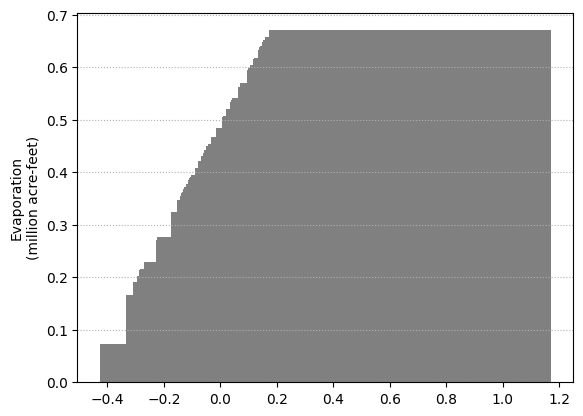

In [37]:
# Use matplotlib

import matplotlib.pyplot as plt

plt.bar(dfWaterYear.wateryear, dfWaterYear.Value, color = "grey", width = 1)
plt.xlabel('')
plt.ylabel('Evaporation\n(million acre-feet)')
plt.grid(axis = 'y', linestyle = "dotted")

#Use ggplot
###(ggplot(dfEvapWaterYear, aes(x = 'wateryear'))
### + geom_bar(aes(y='evaporation'), color = "grey", fill = "grey", stat="identity")
 # geom_line(aes(y=OneYearRelease, group = 1, color="Release"), size=2) +
#  + scale_color_manual("", values = "grey50")
#  + scale_fill_manual("", values = "grey50")
### + labs(x="", y="Evaporation\n(million acre-feet per year)")

 # + theme(text = element_text(size=20), legend.title=element_blank(), legend.text=element_text(size=18),
#        legend.key = element_blank())
###)


# Figure 2. Evaporation each consecutive 10-years

   wateryear  DaysPerYear  evaporation  Evap10yr
0       1964          366     0.073775       NaN
1       1965          365     0.166053       NaN
2       1966          365     0.216575       NaN
3       1967          365     0.191975       NaN
4       1968          366     0.213552       NaN


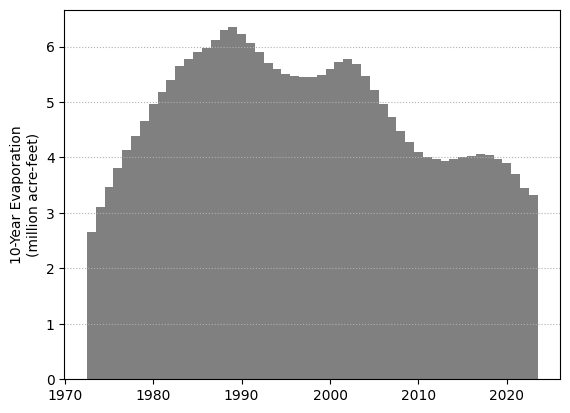

In [17]:
# Calculate a rolling 10-year sum
dfEvap10year = dfEvapWaterYear
dfEvap10year["Evap10yr"] = dfEvap10year['evaporation'].rolling(10).sum()

print(dfEvap10year.head())

plt.bar(dfEvap10year.wateryear, dfEvap10year.Evap10yr, color = "grey", width = 1)
plt.xlabel('')
plt.ylabel('10-Year Evaporation\n(million acre-feet)')
plt.grid(axis = 'y', linestyle = "dotted")